In [1]:
import underworld as uw
import glucifer.pylab as plt
import underworld.function as fn

In [2]:
mesh = uw.mesh.FeMesh_Cartesian('Q1', (128,128), (-2,-1.), (2,1.))
temperatureField = uw.fevariable.FeVariable(mesh,1)

In [3]:
mesh.specialSets.keys()  

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

In [4]:
# declare which nodes are to be considered as boundary nodes
topNodes = mesh.specialSets["MaxJ_VertexSet"] 
bottomNodes = mesh.specialSets["MinJ_VertexSet"]
conditions = uw.conditions.DirichletCondition(temperatureField, topNodes + bottomNodes)

In [5]:
# init tempfield to zero everywhere
temperatureField.data[:] = 0.
# setup required values on boundary nodes
temperatureField.data[topNodes.data]    = 0.
temperatureField.data[bottomNodes.data] = 1.

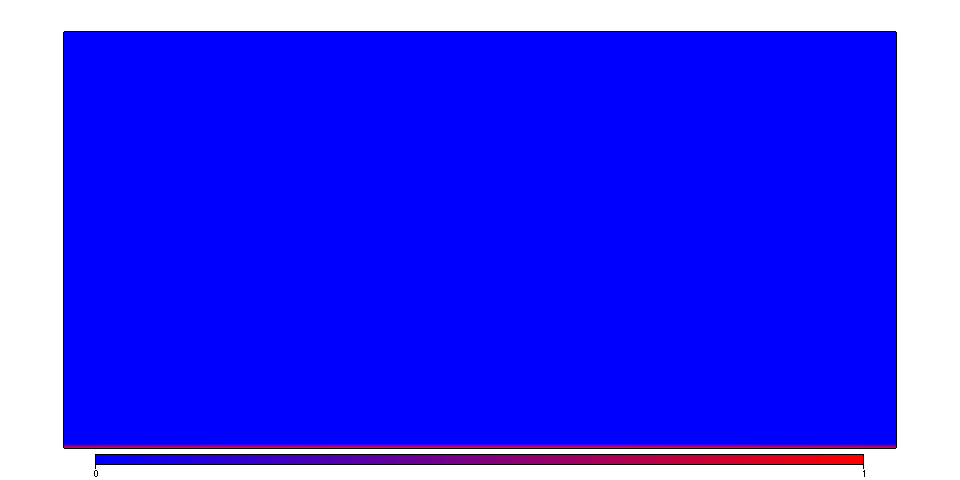

In [6]:
# lets take a look
fig = plt.Figure(figsize=(960, 480))
fig.Surface(temperatureField,mesh, colours=['blue','red'])
fig.show()

In [7]:
# setup system
steadyStateThermal = uw.systems.SteadyStateHeat(temperatureField,1.,conditions=[conditions,])

In [8]:
# solve!
steadyStateThermal.solve()

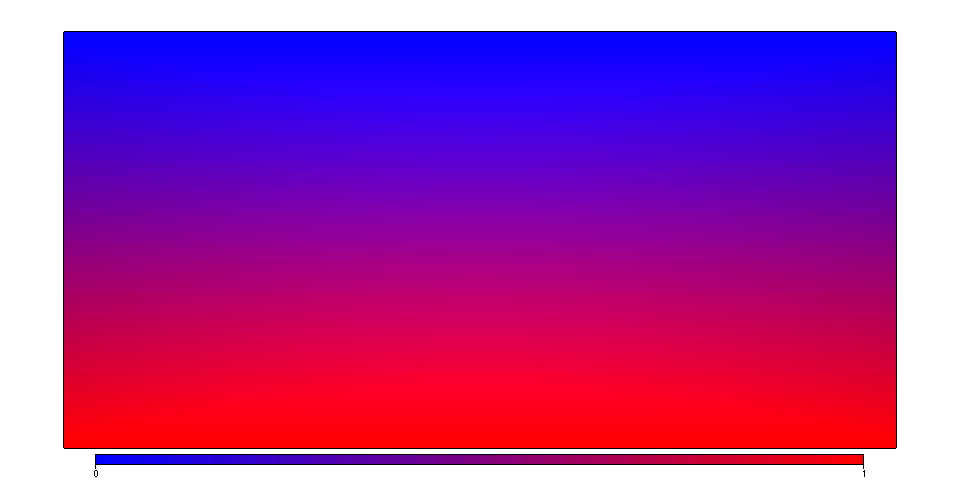

In [9]:
# now lets look
fig = plt.Figure(figsize=(960, 480))
fig.Surface(temperatureField,mesh, colours=['blue','red'])
fig.show()

In [10]:
# wonderous!  now lets change the conductivity function to a function of height
coord = fn.input()
steadyStateThermal.conductivityFn = fn.math.exp(10.*coord[1])

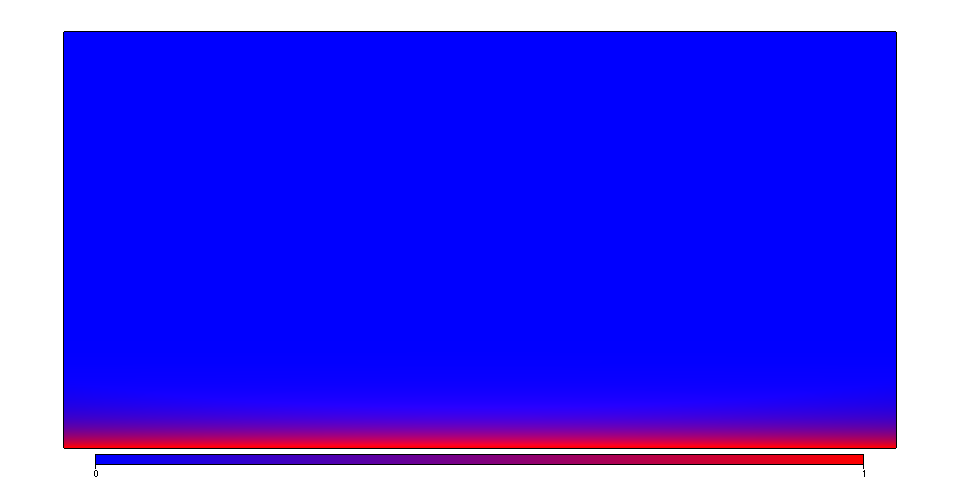

In [11]:
steadyStateThermal.solve()
fig = plt.Figure(figsize=(960, 480))
fig.Surface(temperatureField,mesh, colours=['blue','red'])
fig.show()

In [12]:
# ok, lets introduce a swarm to set some materials
swarm = uw.swarm.Swarm(mesh)

In [13]:
# lets create a variable which will track the material index
index = swarm.add_variable('char',1)
# add particles
layout = uw.swarm.layouts.GlobalSpaceFillerLayout(swarm,20)
swarm.populate_using_layout(layout)

In [14]:
# create some misc shapes
index.data[:] = fn.branching.conditional( [  
            ( coord[0]*coord[0] + coord[1]*coord[1] < 0.5                     , 0),  # circle index is 0
            ( (fn.math.abs(coord[0]) < 0.5) & (fn.math.abs(coord[1])< 0.75)   , 1),  # square index is 1
            ( True                                                            , 2)   # else index is 2
    ] ).evaluate(swarm)

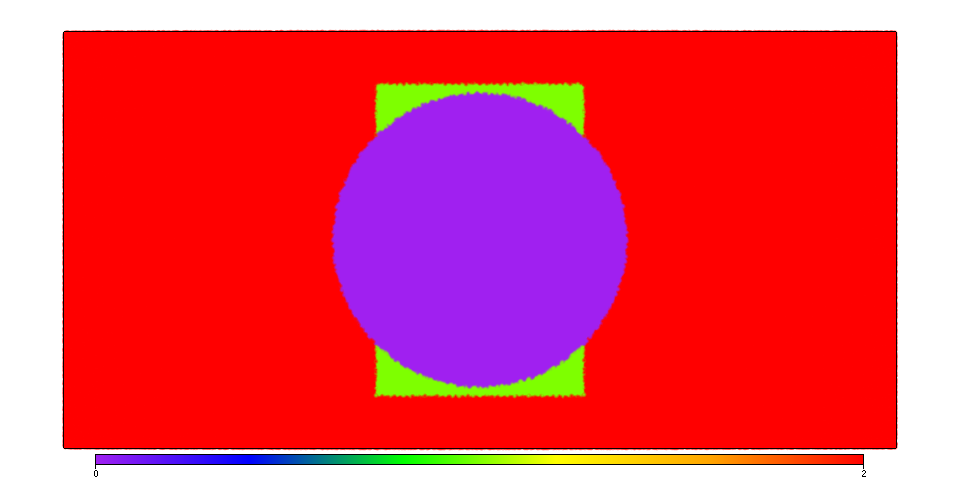

In [15]:
fig = plt.Figure(figsize=(960, 480))
fig.Points(swarm,index,pointSize=4.0)
fig.show()

In [16]:
# now lets map them to conductivities
materialFunction = fn.branching.map(keyFunc=index, mappingDict={0:100., 1:.001, 2:1.})

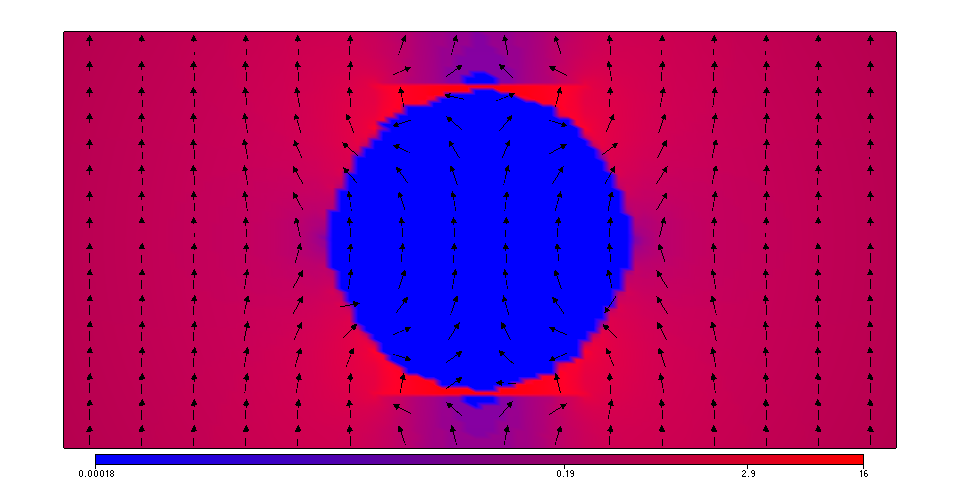

In [17]:
steadyStateThermal.conductivityFn = materialFunction
steadyStateThermal.solve()

heat_flux_Fn = -temperatureField.gradientFn
heat_flux_magnitude_Fn = fn.math.sqrt(fn.math.dot(heat_flux_Fn, heat_flux_Fn))
heat_flux_norm_Fn = heat_flux_Fn / heat_flux_magnitude_Fn

fig = plt.Figure(figsize=(960, 480))
fig.VectorArrows(heat_flux_norm_Fn, mesh, lengthScale=0.1)
fig.Surface(heat_flux_magnitude_Fn,mesh, colours=['blue','red'], logScale=True)
fig.show()

In [18]:
heat_flux_Fn = -temperatureField.gradientFn
heat_flux_magnitude_Fn = fn.math.sqrt(fn.math.dot(heat_flux_Fn, heat_flux_Fn))
heat_flux_norm_Fn = heat_flux_Fn / heat_flux_magnitude_Fn